# Description

This notebook evaluates how a spectral clustering method performs as a consensus function. It takes the coassociation matrix, applies several `delta` values to transform it, and computes different clustering quality measures to assess performance. An optimal `delta` value is chosen, and will be used to perform the full analysis later.

This notebook loads the `z_score_std` data version to compute two of the clustering quality measures (Calinski-Harabasz and Davies-Bouldin). The Silhouette score is computed on the ensemble distance matrix, so it is not affected by the data loaded. There are other two notebooks that perform exactly the same steps here but loading the `pca` and `umap` data versions.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 100000

In [6]:
# output dir for this notebook
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/consensus_clustering')

# Load data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [13]:
traits = data.index.tolist()

In [14]:
len(traits)

3749

# Ensemble (coassociation matrix)

In [15]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "ensemble_coassoc_matrix.npy").resolve()
display(input_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/consensus_clustering/ensemble_coassoc_matrix.npy')

In [16]:
coassoc_matrix = np.load(input_file)

In [17]:
coassoc_matrix = pd.DataFrame(
    data=coassoc_matrix,
    index=traits,
    columns=traits,
)

In [18]:
coassoc_matrix.shape

(3749, 3749)

In [19]:
coassoc_matrix.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
100001_raw-Food_weight,0.000000,0.056159,0.053895,0.076313,0.057518,0.075634,0.074728,0.057971,0.055480,0.567482,...,0.604223,0.602355,0.594564,0.603261,0.582428,0.548731,0.690641,0.599864,0.661714,0.667572
100002_raw-Energy,0.056159,0.000000,0.027400,0.044837,0.021966,0.045743,0.067482,0.031250,0.048007,0.561368,...,0.606040,0.604393,0.594337,0.606431,0.585824,0.571170,0.687644,0.601223,0.659886,0.665308
100003_raw-Protein,0.053895,0.027400,0.000000,0.046875,0.018116,0.047781,0.064764,0.032382,0.050951,0.558424,...,0.602634,0.601676,0.592525,0.603487,0.581975,0.571850,0.691102,0.597826,0.661029,0.662817
100004_raw-Fat,0.076313,0.044837,0.046875,0.000000,0.045516,0.004755,0.046196,0.028306,0.057971,0.551857,...,0.590372,0.589674,0.578256,0.595788,0.571332,0.585902,0.692254,0.588315,0.667429,0.666667
100005_raw-Carbohydrate,0.057518,0.021966,0.018116,0.045516,0.000000,0.046196,0.067935,0.025589,0.050045,0.559783,...,0.605813,0.604393,0.593205,0.604846,0.584692,0.574569,0.687414,0.600543,0.657143,0.662817


In [20]:
dist_matrix = coassoc_matrix

# Clustering

In [21]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

from clustering.utils import compute_performance

## `delta` parameter (gaussian kernel)

### `delta=1.0`

In [22]:
delta = 1.0

In [23]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix ** 2) / (2.0 * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [24]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3179
1     570
dtype: int64

In [25]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.249'

'Calinski-Harabasz (higher is better): 133.181'

'Davies-Bouldin (lower is better): 4.253'

For `delta=1.0`, the algorithm works/converges fine with this data version.

### `delta>1.0`

In [26]:
delta = 10.0

In [27]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix ** 2) / (2.0 * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [28]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3147
1     602
dtype: int64

In [29]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.243'

'Calinski-Harabasz (higher is better): 128.603'

'Davies-Bouldin (lower is better): 4.389'

For `delta` values larger than `1.0`, quality measures go slightly down.

### `delta<1.0`

In [30]:
delta = 0.20

In [31]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix ** 2) / (2.0 * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [32]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3708
1      41
dtype: int64

In [33]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.428'

'Calinski-Harabasz (higher is better): 154.143'

'Davies-Bouldin (lower is better): 1.263'

For `delta` values smaller than `1.0`, quality measures improve.

### `delta<<<1.0`

In [34]:
delta = 0.10

In [35]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix ** 2) / (2.0 * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-4,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [36]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3744
1       5
dtype: int64

In [37]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.364'

'Calinski-Harabasz (higher is better): 40.633'

'Davies-Bouldin (lower is better): 1.045'

For `delta` values around `0.10` the algorithm does not converge, and I need to force convergence with `eigen_tol=1e-4`.

Quality measures in general go down.

## Extended test

In [38]:
from clustering.methods import DeltaSpectralClustering

In [39]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["DELTAS"] = [
    5.00,
    2.00,
    1.00,
    0.90,
    0.75,
    0.50,
    0.30,
    0.25,
    0.20,
]

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'DELTAS': [5.0, 2.0, 1.0, 0.9, 0.75, 0.5, 0.3, 0.25, 0.2]}

In [40]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for delta_value in CLUSTERING_OPTIONS["DELTAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = DeltaSpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                affinity="precomputed",
                delta=delta_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [41]:
display(len(CLUSTERERS))

630

In [42]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DeltaSpectralClustering #0', DeltaSpectralClustering(delta=5.0))

('DeltaSpectralClustering #1', DeltaSpectralClustering(delta=5.0))

In [43]:
clustering_method_name = method_name
display(clustering_method_name)

'DeltaSpectralClustering'

## Generate ensemble

In [44]:
import tempfile
from clustering.ensembles.utils import generate_ensemble

In [45]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    tempfile.gettempdir(),
    f"pre_cluster_analysis",
    clustering_method_name,
).resolve()
ensemble_folder.mkdir(parents=True, exist_ok=True)

In [46]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(CLUSTERING_OPTIONS, prefix=f"ensemble-", suffix=".pkl"),
)
display(ensemble_file)

PosixPath('/tmp/pre_cluster_analysis/DeltaSpectralClustering/ensemble-DELTAS_50_20_10_09_075_05_03_025_02-KMEANS_N_INIT_10-K_RANGE_2_4_6_8_10_12_14_16_18_20_25_30_35_40-N_REPS_PER_K_5.pkl')

In [47]:
if ensemble_file.exists():
    display(f"Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        dist_matrix,
        CLUSTERERS,
        attributes=["n_clusters", "delta"],
    )

  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 1/630 [00:01<12:10,  1.16s/it]

  0%|          | 2/630 [00:02<12:10,  1.16s/it]

  0%|          | 3/630 [00:03<12:09,  1.16s/it]

  1%|          | 4/630 [00:04<12:08,  1.16s/it]

  1%|          | 5/630 [00:05<12:08,  1.17s/it]

  1%|          | 6/630 [00:06<12:06,  1.16s/it]

  1%|          | 7/630 [00:08<12:04,  1.16s/it]

  1%|▏         | 8/630 [00:09<12:03,  1.16s/it]

  1%|▏         | 9/630 [00:10<12:02,  1.16s/it]

  2%|▏         | 10/630 [00:11<12:01,  1.16s/it]

  2%|▏         | 11/630 [00:12<11:59,  1.16s/it]

  2%|▏         | 12/630 [00:13<11:57,  1.16s/it]

  2%|▏         | 13/630 [00:15<11:56,  1.16s/it]

  2%|▏         | 14/630 [00:16<11:55,  1.16s/it]

  2%|▏         | 15/630 [00:17<11:54,  1.16s/it]

  3%|▎         | 16/630 [00:18<11:52,  1.16s/it]

  3%|▎         | 17/630 [00:19<11:53,  1.16s/it]

  3%|▎         | 18/630 [00:20<11:51,  1.16s/it]

  3%|▎         | 19/630 [00:22<11:50,  1.16s/it]

  3%|▎         | 20/630 [00:23<11:48,  1.16s/it]

  3%|▎         | 21/630 [00:24<11:47,  1.16s/it]

  3%|▎         | 22/630 [00:25<11:46,  1.16s/it]

  4%|▎         | 23/630 [00:26<11:45,  1.16s/it]

  4%|▍         | 24/630 [00:27<11:45,  1.16s/it]

  4%|▍         | 25/630 [00:29<11:43,  1.16s/it]

  4%|▍         | 26/630 [00:30<11:44,  1.17s/it]

  4%|▍         | 27/630 [00:31<11:42,  1.16s/it]

  4%|▍         | 28/630 [00:32<11:39,  1.16s/it]

  5%|▍         | 29/630 [00:33<11:40,  1.16s/it]

  5%|▍         | 30/630 [00:34<11:38,  1.16s/it]

  5%|▍         | 31/630 [00:36<11:35,  1.16s/it]

  5%|▌         | 32/630 [00:37<11:35,  1.16s/it]

  5%|▌         | 33/630 [00:38<11:32,  1.16s/it]

  5%|▌         | 34/630 [00:39<11:47,  1.19s/it]

  6%|▌         | 35/630 [00:40<11:40,  1.18s/it]

  6%|▌         | 36/630 [00:42<11:54,  1.20s/it]

  6%|▌         | 37/630 [00:43<12:01,  1.22s/it]

  6%|▌         | 38/630 [00:44<12:06,  1.23s/it]

  6%|▌         | 39/630 [00:45<12:10,  1.24s/it]

  6%|▋         | 40/630 [00:47<12:13,  1.24s/it]

  7%|▋         | 41/630 [00:48<12:33,  1.28s/it]

  7%|▋         | 42/630 [00:49<12:47,  1.31s/it]

  7%|▋         | 43/630 [00:51<12:57,  1.33s/it]

  7%|▋         | 44/630 [00:52<13:07,  1.34s/it]

  7%|▋         | 45/630 [00:53<13:12,  1.35s/it]

  7%|▋         | 46/630 [00:55<12:52,  1.32s/it]

  7%|▋         | 47/630 [00:56<13:25,  1.38s/it]

  8%|▊         | 48/630 [00:58<13:47,  1.42s/it]

  8%|▊         | 49/630 [00:59<13:18,  1.37s/it]

  8%|▊         | 50/630 [01:01<13:50,  1.43s/it]

  8%|▊         | 51/630 [01:02<13:43,  1.42s/it]

  8%|▊         | 52/630 [01:03<13:55,  1.45s/it]

  8%|▊         | 53/630 [01:05<13:22,  1.39s/it]

  9%|▊         | 54/630 [01:06<13:12,  1.38s/it]

  9%|▊         | 55/630 [01:07<13:15,  1.38s/it]

  9%|▉         | 56/630 [01:09<13:33,  1.42s/it]

  9%|▉         | 57/630 [01:10<13:05,  1.37s/it]

  9%|▉         | 58/630 [01:11<12:49,  1.34s/it]

  9%|▉         | 59/630 [01:13<13:39,  1.43s/it]

 10%|▉         | 60/630 [01:15<14:09,  1.49s/it]

 10%|▉         | 61/630 [01:16<13:30,  1.42s/it]

 10%|▉         | 62/630 [01:18<13:50,  1.46s/it]

 10%|█         | 63/630 [01:19<14:04,  1.49s/it]

 10%|█         | 64/630 [01:21<13:47,  1.46s/it]

 10%|█         | 65/630 [01:22<14:19,  1.52s/it]

 10%|█         | 66/630 [01:24<13:49,  1.47s/it]

 11%|█         | 67/630 [01:25<13:41,  1.46s/it]

 11%|█         | 68/630 [01:26<13:34,  1.45s/it]

 11%|█         | 69/630 [01:28<13:04,  1.40s/it]

 11%|█         | 70/630 [01:29<12:40,  1.36s/it]

 11%|█▏        | 71/630 [01:30<12:21,  1.33s/it]

 11%|█▏        | 72/630 [01:32<12:47,  1.37s/it]

 12%|█▏        | 73/630 [01:33<12:56,  1.39s/it]

 12%|█▏        | 74/630 [01:35<13:01,  1.41s/it]

 12%|█▏        | 75/630 [01:36<13:26,  1.45s/it]

 12%|█▏        | 76/630 [01:37<12:52,  1.39s/it]

 12%|█▏        | 77/630 [01:39<12:41,  1.38s/it]

 12%|█▏        | 78/630 [01:40<12:45,  1.39s/it]

 13%|█▎        | 79/630 [01:42<13:18,  1.45s/it]

 13%|█▎        | 80/630 [01:43<12:46,  1.39s/it]

 13%|█▎        | 81/630 [01:45<13:12,  1.44s/it]

 13%|█▎        | 82/630 [01:46<13:19,  1.46s/it]

 13%|█▎        | 83/630 [01:48<13:31,  1.48s/it]

 13%|█▎        | 84/630 [01:49<12:52,  1.42s/it]

 13%|█▎        | 85/630 [01:51<13:36,  1.50s/it]

 14%|█▎        | 86/630 [01:52<13:21,  1.47s/it]

 14%|█▍        | 87/630 [01:54<13:38,  1.51s/it]

 14%|█▍        | 88/630 [01:55<14:25,  1.60s/it]

 14%|█▍        | 89/630 [01:57<13:58,  1.55s/it]

 14%|█▍        | 90/630 [01:58<13:42,  1.52s/it]

 14%|█▍        | 91/630 [02:00<13:17,  1.48s/it]

 15%|█▍        | 92/630 [02:01<13:07,  1.46s/it]

 15%|█▍        | 93/630 [02:02<12:58,  1.45s/it]

 15%|█▍        | 94/630 [02:05<14:38,  1.64s/it]

 15%|█▌        | 95/630 [02:06<14:52,  1.67s/it]

 15%|█▌        | 96/630 [02:08<14:10,  1.59s/it]

 15%|█▌        | 97/630 [02:10<15:12,  1.71s/it]

 16%|█▌        | 98/630 [02:11<14:09,  1.60s/it]

 16%|█▌        | 99/630 [02:12<13:28,  1.52s/it]

 16%|█▌        | 100/630 [02:14<13:12,  1.50s/it]

 16%|█▌        | 101/630 [02:15<12:45,  1.45s/it]

 16%|█▌        | 102/630 [02:17<13:50,  1.57s/it]

 16%|█▋        | 103/630 [02:18<13:25,  1.53s/it]

 17%|█▋        | 104/630 [02:20<13:51,  1.58s/it]

 17%|█▋        | 105/630 [02:22<13:26,  1.54s/it]

 17%|█▋        | 106/630 [02:23<13:42,  1.57s/it]

 17%|█▋        | 107/630 [02:25<14:52,  1.71s/it]

 17%|█▋        | 108/630 [02:27<13:50,  1.59s/it]

 17%|█▋        | 109/630 [02:28<13:44,  1.58s/it]

 17%|█▋        | 110/630 [02:30<14:35,  1.68s/it]

 18%|█▊        | 111/630 [02:31<13:40,  1.58s/it]

 18%|█▊        | 112/630 [02:33<13:37,  1.58s/it]

 18%|█▊        | 113/630 [02:34<13:11,  1.53s/it]

 18%|█▊        | 114/630 [02:36<13:58,  1.62s/it]

 18%|█▊        | 115/630 [02:38<14:05,  1.64s/it]

 18%|█▊        | 116/630 [02:39<13:27,  1.57s/it]

 19%|█▊        | 117/630 [02:41<12:55,  1.51s/it]

 19%|█▊        | 118/630 [02:42<13:18,  1.56s/it]

 19%|█▉        | 119/630 [02:44<12:55,  1.52s/it]

 19%|█▉        | 120/630 [02:45<13:12,  1.55s/it]

 19%|█▉        | 121/630 [02:47<13:04,  1.54s/it]

 19%|█▉        | 122/630 [02:48<13:06,  1.55s/it]

 20%|█▉        | 123/630 [02:50<12:54,  1.53s/it]

 20%|█▉        | 124/630 [02:51<12:22,  1.47s/it]

 20%|█▉        | 125/630 [02:53<12:36,  1.50s/it]

 20%|██        | 126/630 [02:54<12:09,  1.45s/it]

 20%|██        | 127/630 [02:56<12:39,  1.51s/it]

 20%|██        | 128/630 [02:57<13:00,  1.56s/it]

 20%|██        | 129/630 [02:59<12:41,  1.52s/it]

 21%|██        | 130/630 [03:00<12:09,  1.46s/it]

 21%|██        | 131/630 [03:02<13:21,  1.61s/it]

 21%|██        | 132/630 [03:04<14:05,  1.70s/it]

 21%|██        | 133/630 [03:06<13:45,  1.66s/it]

 21%|██▏       | 134/630 [03:07<13:36,  1.65s/it]

 21%|██▏       | 135/630 [03:09<13:30,  1.64s/it]

 22%|██▏       | 136/630 [03:10<12:55,  1.57s/it]

 22%|██▏       | 137/630 [03:12<13:52,  1.69s/it]

 22%|██▏       | 138/630 [03:14<14:58,  1.83s/it]

 22%|██▏       | 139/630 [03:16<13:53,  1.70s/it]

 22%|██▏       | 140/630 [03:17<13:35,  1.66s/it]

 22%|██▏       | 141/630 [03:19<13:24,  1.65s/it]

 23%|██▎       | 142/630 [03:20<12:47,  1.57s/it]

 23%|██▎       | 143/630 [03:22<12:39,  1.56s/it]

 23%|██▎       | 144/630 [03:23<12:14,  1.51s/it]

 23%|██▎       | 145/630 [03:25<12:29,  1.55s/it]

 23%|██▎       | 146/630 [03:26<12:09,  1.51s/it]

 23%|██▎       | 147/630 [03:28<11:58,  1.49s/it]

 23%|██▎       | 148/630 [03:29<11:53,  1.48s/it]

 24%|██▎       | 149/630 [03:31<13:11,  1.65s/it]

 24%|██▍       | 150/630 [03:33<13:57,  1.75s/it]

 24%|██▍       | 151/630 [03:35<13:13,  1.66s/it]

 24%|██▍       | 152/630 [03:36<12:44,  1.60s/it]

 24%|██▍       | 153/630 [03:38<12:20,  1.55s/it]

 24%|██▍       | 154/630 [03:40<13:49,  1.74s/it]

 25%|██▍       | 155/630 [03:41<13:07,  1.66s/it]

 25%|██▍       | 156/630 [03:43<13:49,  1.75s/it]

 25%|██▍       | 157/630 [03:45<13:04,  1.66s/it]

 25%|██▌       | 158/630 [03:46<12:33,  1.60s/it]

 25%|██▌       | 159/630 [03:48<12:11,  1.55s/it]

 25%|██▌       | 160/630 [03:49<12:07,  1.55s/it]

 26%|██▌       | 161/630 [03:51<11:42,  1.50s/it]

 26%|██▌       | 162/630 [03:52<11:39,  1.50s/it]

 26%|██▌       | 163/630 [03:53<11:21,  1.46s/it]

 26%|██▌       | 164/630 [03:55<11:10,  1.44s/it]

 26%|██▌       | 165/630 [03:56<11:24,  1.47s/it]

 26%|██▋       | 166/630 [03:58<11:34,  1.50s/it]

 27%|██▋       | 167/630 [03:59<11:28,  1.49s/it]

 27%|██▋       | 168/630 [04:01<11:51,  1.54s/it]

 27%|██▋       | 169/630 [04:03<12:03,  1.57s/it]

 27%|██▋       | 170/630 [04:04<12:01,  1.57s/it]

 27%|██▋       | 171/630 [04:06<11:59,  1.57s/it]

 27%|██▋       | 172/630 [04:08<12:26,  1.63s/it]

 27%|██▋       | 173/630 [04:09<12:19,  1.62s/it]

 28%|██▊       | 174/630 [04:10<11:37,  1.53s/it]

 28%|██▊       | 175/630 [04:12<11:54,  1.57s/it]

 28%|██▊       | 176/630 [04:14<11:25,  1.51s/it]

 28%|██▊       | 177/630 [04:15<11:17,  1.50s/it]

 28%|██▊       | 178/630 [04:17<11:25,  1.52s/it]

 28%|██▊       | 179/630 [04:18<11:08,  1.48s/it]

 29%|██▊       | 180/630 [04:19<10:58,  1.46s/it]

 29%|██▊       | 181/630 [04:22<12:36,  1.69s/it]

 29%|██▉       | 182/630 [04:24<13:45,  1.84s/it]

 29%|██▉       | 183/630 [04:25<13:16,  1.78s/it]

 29%|██▉       | 184/630 [04:27<12:44,  1.71s/it]

 29%|██▉       | 185/630 [04:28<12:15,  1.65s/it]

 30%|██▉       | 186/630 [04:31<13:13,  1.79s/it]

 30%|██▉       | 187/630 [04:32<12:32,  1.70s/it]

 30%|██▉       | 188/630 [04:34<13:44,  1.87s/it]

 30%|███       | 189/630 [04:36<13:04,  1.78s/it]

 30%|███       | 190/630 [04:37<12:28,  1.70s/it]

 30%|███       | 191/630 [04:39<12:01,  1.64s/it]

 30%|███       | 192/630 [04:40<11:42,  1.60s/it]

 31%|███       | 193/630 [04:42<11:37,  1.60s/it]

 31%|███       | 194/630 [04:44<12:57,  1.78s/it]

 31%|███       | 195/630 [04:46<12:19,  1.70s/it]

 31%|███       | 196/630 [04:47<11:53,  1.64s/it]

 31%|███▏      | 197/630 [04:49<12:45,  1.77s/it]

 31%|███▏      | 198/630 [04:51<12:17,  1.71s/it]

 32%|███▏      | 199/630 [04:52<12:01,  1.67s/it]

 32%|███▏      | 200/630 [04:54<11:50,  1.65s/it]

 32%|███▏      | 201/630 [04:56<11:38,  1.63s/it]

 32%|███▏      | 202/630 [04:57<11:29,  1.61s/it]

 32%|███▏      | 203/630 [04:59<11:17,  1.59s/it]

 32%|███▏      | 204/630 [05:00<11:03,  1.56s/it]

 33%|███▎      | 205/630 [05:02<11:06,  1.57s/it]

 33%|███▎      | 206/630 [05:04<11:25,  1.62s/it]

 33%|███▎      | 207/630 [05:06<12:40,  1.80s/it]

 33%|███▎      | 208/630 [05:07<11:57,  1.70s/it]

 33%|███▎      | 209/630 [05:09<11:46,  1.68s/it]

 33%|███▎      | 210/630 [05:11<12:22,  1.77s/it]

 33%|███▎      | 211/630 [05:13<12:32,  1.79s/it]

 34%|███▎      | 212/630 [05:14<11:44,  1.69s/it]

 34%|███▍      | 213/630 [05:16<12:06,  1.74s/it]

 34%|███▍      | 214/630 [05:18<11:41,  1.69s/it]

 34%|███▍      | 215/630 [05:19<12:05,  1.75s/it]

 34%|███▍      | 216/630 [05:21<11:20,  1.64s/it]

 34%|███▍      | 217/630 [05:22<10:45,  1.56s/it]

 35%|███▍      | 218/630 [05:24<10:54,  1.59s/it]

 35%|███▍      | 219/630 [05:25<10:35,  1.55s/it]

 35%|███▍      | 220/630 [05:27<10:38,  1.56s/it]

 35%|███▌      | 221/630 [05:29<10:52,  1.60s/it]

 35%|███▌      | 222/630 [05:30<10:41,  1.57s/it]

 35%|███▌      | 223/630 [05:32<11:27,  1.69s/it]

 36%|███▌      | 224/630 [05:34<11:24,  1.69s/it]

 36%|███▌      | 225/630 [05:36<11:37,  1.72s/it]

 36%|███▌      | 226/630 [05:37<11:11,  1.66s/it]

 36%|███▌      | 227/630 [05:39<11:00,  1.64s/it]

 36%|███▌      | 228/630 [05:41<11:27,  1.71s/it]

 36%|███▋      | 229/630 [05:43<12:29,  1.87s/it]

 37%|███▋      | 230/630 [05:45<12:15,  1.84s/it]

 37%|███▋      | 231/630 [05:46<11:49,  1.78s/it]

 37%|███▋      | 232/630 [05:48<12:37,  1.90s/it]

 37%|███▋      | 233/630 [05:50<11:53,  1.80s/it]

 37%|███▋      | 234/630 [05:52<11:53,  1.80s/it]

 37%|███▋      | 235/630 [05:54<12:27,  1.89s/it]

 37%|███▋      | 236/630 [05:55<11:50,  1.80s/it]

 38%|███▊      | 237/630 [05:57<11:30,  1.76s/it]

 38%|███▊      | 238/630 [05:59<11:12,  1.72s/it]

 38%|███▊      | 239/630 [06:00<11:00,  1.69s/it]

 38%|███▊      | 240/630 [06:03<12:05,  1.86s/it]

 38%|███▊      | 241/630 [06:04<11:25,  1.76s/it]

 38%|███▊      | 242/630 [06:06<10:57,  1.69s/it]

 39%|███▊      | 243/630 [06:08<12:01,  1.86s/it]

 39%|███▊      | 244/630 [06:10<12:05,  1.88s/it]

 39%|███▉      | 245/630 [06:11<11:27,  1.79s/it]

 39%|███▉      | 246/630 [06:13<11:34,  1.81s/it]

 39%|███▉      | 247/630 [06:16<12:24,  1.94s/it]

 39%|███▉      | 248/630 [06:17<11:46,  1.85s/it]

 40%|███▉      | 249/630 [06:19<11:22,  1.79s/it]

 40%|███▉      | 250/630 [06:21<11:40,  1.84s/it]

 40%|███▉      | 251/630 [06:22<11:07,  1.76s/it]

 40%|████      | 252/630 [06:25<11:49,  1.88s/it]

 40%|████      | 253/630 [06:26<11:29,  1.83s/it]

 40%|████      | 254/630 [06:28<11:32,  1.84s/it]

 40%|████      | 255/630 [06:30<11:16,  1.80s/it]

 41%|████      | 256/630 [06:31<10:46,  1.73s/it]

 41%|████      | 257/630 [06:33<10:33,  1.70s/it]

 41%|████      | 258/630 [06:35<10:12,  1.65s/it]

 41%|████      | 259/630 [06:36<10:11,  1.65s/it]

 41%|████▏     | 260/630 [06:38<11:15,  1.82s/it]

 41%|████▏     | 261/630 [06:40<11:34,  1.88s/it]

 42%|████▏     | 262/630 [06:42<10:58,  1.79s/it]

 42%|████▏     | 263/630 [06:44<11:27,  1.87s/it]

 42%|████▏     | 264/630 [06:46<10:47,  1.77s/it]

 42%|████▏     | 265/630 [06:47<10:27,  1.72s/it]

 42%|████▏     | 266/630 [06:49<10:10,  1.68s/it]

 42%|████▏     | 267/630 [06:50<09:54,  1.64s/it]

 43%|████▎     | 268/630 [06:52<10:28,  1.74s/it]

 43%|████▎     | 269/630 [06:54<10:16,  1.71s/it]

 43%|████▎     | 270/630 [06:56<10:46,  1.79s/it]

 43%|████▎     | 271/630 [06:58<10:33,  1.76s/it]

 43%|████▎     | 272/630 [06:59<10:25,  1.75s/it]

 43%|████▎     | 273/630 [07:01<10:41,  1.80s/it]

 43%|████▎     | 274/630 [07:03<10:25,  1.76s/it]

 44%|████▎     | 275/630 [07:05<10:51,  1.83s/it]

 44%|████▍     | 276/630 [07:07<10:37,  1.80s/it]

 44%|████▍     | 277/630 [07:08<10:26,  1.77s/it]

 44%|████▍     | 278/630 [07:10<10:16,  1.75s/it]

 44%|████▍     | 279/630 [07:12<09:58,  1.71s/it]

 44%|████▍     | 280/630 [07:13<09:49,  1.68s/it]

 45%|████▍     | 281/630 [07:15<10:01,  1.72s/it]

 45%|████▍     | 282/630 [07:17<10:01,  1.73s/it]

 45%|████▍     | 283/630 [07:19<09:57,  1.72s/it]

 45%|████▌     | 284/630 [07:21<10:50,  1.88s/it]

 45%|████▌     | 285/630 [07:23<10:31,  1.83s/it]

 45%|████▌     | 286/630 [07:24<10:11,  1.78s/it]

 46%|████▌     | 287/630 [07:26<09:55,  1.74s/it]

 46%|████▌     | 288/630 [07:28<09:54,  1.74s/it]

 46%|████▌     | 289/630 [07:29<09:41,  1.70s/it]

 46%|████▌     | 290/630 [07:31<09:46,  1.72s/it]

 46%|████▌     | 291/630 [07:33<10:20,  1.83s/it]

 46%|████▋     | 292/630 [07:35<10:48,  1.92s/it]

 47%|████▋     | 293/630 [07:37<11:04,  1.97s/it]

 47%|████▋     | 294/630 [07:40<11:38,  2.08s/it]

 47%|████▋     | 295/630 [07:41<10:51,  1.94s/it]

 47%|████▋     | 296/630 [07:43<10:15,  1.84s/it]

 47%|████▋     | 297/630 [07:44<09:53,  1.78s/it]

 47%|████▋     | 298/630 [07:47<10:46,  1.95s/it]

 47%|████▋     | 299/630 [07:49<11:19,  2.05s/it]

 48%|████▊     | 300/630 [07:51<11:17,  2.05s/it]

 48%|████▊     | 301/630 [07:53<10:33,  1.93s/it]

 48%|████▊     | 302/630 [07:55<10:36,  1.94s/it]

 48%|████▊     | 303/630 [07:56<10:07,  1.86s/it]

 48%|████▊     | 304/630 [07:58<09:45,  1.80s/it]

 48%|████▊     | 305/630 [08:00<10:07,  1.87s/it]

 49%|████▊     | 306/630 [08:02<09:38,  1.78s/it]

 49%|████▊     | 307/630 [08:03<09:27,  1.76s/it]

 49%|████▉     | 308/630 [08:05<09:09,  1.71s/it]

 49%|████▉     | 309/630 [08:07<08:56,  1.67s/it]

 49%|████▉     | 310/630 [08:08<09:17,  1.74s/it]

 49%|████▉     | 311/630 [08:10<09:43,  1.83s/it]

 50%|████▉     | 312/630 [08:12<09:16,  1.75s/it]

 50%|████▉     | 313/630 [08:14<09:36,  1.82s/it]

 50%|████▉     | 314/630 [08:16<09:37,  1.83s/it]

 50%|█████     | 315/630 [08:18<09:24,  1.79s/it]

 50%|█████     | 316/630 [08:20<10:10,  1.94s/it]

 50%|█████     | 317/630 [08:22<10:11,  1.95s/it]

 50%|█████     | 318/630 [08:24<09:49,  1.89s/it]

 51%|█████     | 319/630 [08:25<09:34,  1.85s/it]

 51%|█████     | 320/630 [08:27<09:25,  1.82s/it]

 51%|█████     | 321/630 [08:29<09:09,  1.78s/it]

 51%|█████     | 322/630 [08:31<09:11,  1.79s/it]

 51%|█████▏    | 323/630 [08:32<09:06,  1.78s/it]

 51%|█████▏    | 324/630 [08:34<09:05,  1.78s/it]

 52%|█████▏    | 325/630 [08:36<09:35,  1.89s/it]

 52%|█████▏    | 326/630 [08:38<09:26,  1.87s/it]

 52%|█████▏    | 327/630 [08:40<09:07,  1.81s/it]

 52%|█████▏    | 328/630 [08:42<09:00,  1.79s/it]

 52%|█████▏    | 329/630 [08:43<08:57,  1.79s/it]

 52%|█████▏    | 330/630 [08:45<09:26,  1.89s/it]

 53%|█████▎    | 331/630 [08:48<10:09,  2.04s/it]

 53%|█████▎    | 332/630 [08:50<10:00,  2.01s/it]

 53%|█████▎    | 333/630 [08:52<09:32,  1.93s/it]

 53%|█████▎    | 334/630 [08:53<09:07,  1.85s/it]

 53%|█████▎    | 335/630 [08:55<08:56,  1.82s/it]

 53%|█████▎    | 336/630 [08:57<08:53,  1.81s/it]

 53%|█████▎    | 337/630 [08:58<08:41,  1.78s/it]

 54%|█████▎    | 338/630 [09:00<08:28,  1.74s/it]

 54%|█████▍    | 339/630 [09:02<08:27,  1.74s/it]

 54%|█████▍    | 340/630 [09:04<08:31,  1.76s/it]

 54%|█████▍    | 341/630 [09:06<09:24,  1.95s/it]

 54%|█████▍    | 342/630 [09:08<09:54,  2.07s/it]

 54%|█████▍    | 343/630 [09:10<09:24,  1.97s/it]

 55%|█████▍    | 344/630 [09:12<09:27,  1.98s/it]

 55%|█████▍    | 345/630 [09:14<09:23,  1.98s/it]

 55%|█████▍    | 346/630 [09:16<08:50,  1.87s/it]

 55%|█████▌    | 347/630 [09:17<08:31,  1.81s/it]

 55%|█████▌    | 348/630 [09:19<08:14,  1.75s/it]

 55%|█████▌    | 349/630 [09:21<08:08,  1.74s/it]

 56%|█████▌    | 350/630 [09:23<08:40,  1.86s/it]

 56%|█████▌    | 351/630 [09:25<08:44,  1.88s/it]

 56%|█████▌    | 352/630 [09:27<08:43,  1.88s/it]

 56%|█████▌    | 353/630 [09:29<08:52,  1.92s/it]

 56%|█████▌    | 354/630 [09:31<08:47,  1.91s/it]

 56%|█████▋    | 355/630 [09:33<08:59,  1.96s/it]

 57%|█████▋    | 356/630 [09:34<08:29,  1.86s/it]

 57%|█████▋    | 357/630 [09:36<08:05,  1.78s/it]

 57%|█████▋    | 358/630 [09:38<08:04,  1.78s/it]

 57%|█████▋    | 359/630 [09:39<07:47,  1.72s/it]

 57%|█████▋    | 360/630 [09:41<07:59,  1.77s/it]

 57%|█████▋    | 361/630 [09:43<07:55,  1.77s/it]

 57%|█████▋    | 362/630 [09:45<08:17,  1.86s/it]

 58%|█████▊    | 363/630 [09:47<08:36,  1.93s/it]

 58%|█████▊    | 364/630 [09:49<08:21,  1.88s/it]

 58%|█████▊    | 365/630 [09:51<08:13,  1.86s/it]

 58%|█████▊    | 366/630 [09:53<08:35,  1.95s/it]

 58%|█████▊    | 367/630 [09:55<08:40,  1.98s/it]

 58%|█████▊    | 368/630 [09:57<08:24,  1.92s/it]

 59%|█████▊    | 369/630 [09:59<08:25,  1.94s/it]

 59%|█████▊    | 370/630 [10:00<08:13,  1.90s/it]

 59%|█████▉    | 371/630 [10:02<08:13,  1.91s/it]

 59%|█████▉    | 372/630 [10:04<07:59,  1.86s/it]

 59%|█████▉    | 373/630 [10:06<07:55,  1.85s/it]

 59%|█████▉    | 374/630 [10:08<08:13,  1.93s/it]

 60%|█████▉    | 375/630 [10:10<08:17,  1.95s/it]

 60%|█████▉    | 376/630 [10:12<08:15,  1.95s/it]

 60%|█████▉    | 377/630 [10:14<08:14,  1.95s/it]

 60%|██████    | 378/630 [10:16<08:16,  1.97s/it]

 60%|██████    | 379/630 [10:18<08:07,  1.94s/it]

 60%|██████    | 380/630 [10:20<08:40,  2.08s/it]

 60%|██████    | 381/630 [10:22<08:27,  2.04s/it]

 61%|██████    | 382/630 [10:24<08:13,  1.99s/it]

 61%|██████    | 383/630 [10:26<08:06,  1.97s/it]

 61%|██████    | 384/630 [10:29<08:50,  2.16s/it]

 61%|██████    | 385/630 [10:30<08:25,  2.06s/it]

 61%|██████▏   | 386/630 [10:32<08:02,  1.98s/it]

 61%|██████▏   | 387/630 [10:34<07:47,  1.92s/it]

 62%|██████▏   | 388/630 [10:36<07:37,  1.89s/it]

 62%|██████▏   | 389/630 [10:38<07:33,  1.88s/it]

 62%|██████▏   | 390/630 [10:39<07:27,  1.86s/it]

 62%|██████▏   | 391/630 [10:41<07:24,  1.86s/it]

 62%|██████▏   | 392/630 [10:43<07:17,  1.84s/it]

 62%|██████▏   | 393/630 [10:45<07:21,  1.86s/it]

 63%|██████▎   | 394/630 [10:47<07:41,  1.96s/it]

 63%|██████▎   | 395/630 [10:49<07:53,  2.02s/it]

 63%|██████▎   | 396/630 [10:51<07:34,  1.94s/it]

 63%|██████▎   | 397/630 [10:53<07:17,  1.88s/it]

 63%|██████▎   | 398/630 [10:55<07:16,  1.88s/it]

 63%|██████▎   | 399/630 [10:56<07:03,  1.84s/it]

 63%|██████▎   | 400/630 [10:59<07:35,  1.98s/it]

 64%|██████▎   | 401/630 [11:00<07:04,  1.86s/it]

 64%|██████▍   | 402/630 [11:02<07:13,  1.90s/it]

 64%|██████▍   | 403/630 [11:04<06:48,  1.80s/it]

 64%|██████▍   | 404/630 [11:06<07:11,  1.91s/it]

 64%|██████▍   | 405/630 [11:08<06:45,  1.80s/it]

 64%|██████▍   | 406/630 [11:10<07:15,  1.94s/it]

 65%|██████▍   | 407/630 [11:12<07:17,  1.96s/it]

 65%|██████▍   | 408/630 [11:14<07:20,  1.98s/it]

 65%|██████▍   | 409/630 [11:16<07:07,  1.94s/it]

 65%|██████▌   | 410/630 [11:18<07:19,  2.00s/it]

 65%|██████▌   | 411/630 [11:20<07:06,  1.95s/it]

 65%|██████▌   | 412/630 [11:22<07:00,  1.93s/it]

 66%|██████▌   | 413/630 [11:24<07:07,  1.97s/it]

 66%|██████▌   | 414/630 [11:26<06:59,  1.94s/it]

 66%|██████▌   | 415/630 [11:28<07:04,  1.98s/it]

 66%|██████▌   | 416/630 [11:30<07:21,  2.06s/it]

 66%|██████▌   | 417/630 [11:32<07:06,  2.00s/it]

 66%|██████▋   | 418/630 [11:34<07:31,  2.13s/it]

 67%|██████▋   | 419/630 [11:36<07:25,  2.11s/it]

 67%|██████▋   | 420/630 [11:38<07:16,  2.08s/it]

 67%|██████▋   | 421/630 [11:40<07:09,  2.06s/it]

 67%|██████▋   | 422/630 [11:42<07:00,  2.02s/it]

 67%|██████▋   | 423/630 [11:44<07:01,  2.04s/it]

 67%|██████▋   | 424/630 [11:46<06:57,  2.03s/it]

 67%|██████▋   | 425/630 [11:48<06:46,  1.98s/it]

 68%|██████▊   | 426/630 [11:51<07:14,  2.13s/it]

 68%|██████▊   | 427/630 [11:53<07:03,  2.09s/it]

 68%|██████▊   | 428/630 [11:54<06:49,  2.03s/it]

 68%|██████▊   | 429/630 [11:57<06:46,  2.02s/it]

 68%|██████▊   | 430/630 [11:59<06:46,  2.03s/it]

 68%|██████▊   | 431/630 [12:01<06:42,  2.02s/it]

 69%|██████▊   | 432/630 [12:02<06:26,  1.95s/it]

 69%|██████▊   | 433/630 [12:05<06:46,  2.06s/it]

 69%|██████▉   | 434/630 [12:07<06:50,  2.09s/it]

 69%|██████▉   | 435/630 [12:09<06:52,  2.12s/it]

 69%|██████▉   | 436/630 [12:11<06:38,  2.06s/it]

 69%|██████▉   | 437/630 [12:13<06:39,  2.07s/it]

 70%|██████▉   | 438/630 [12:15<06:20,  1.98s/it]

 70%|██████▉   | 439/630 [12:17<06:20,  1.99s/it]

 70%|██████▉   | 440/630 [12:19<06:21,  2.01s/it]

 70%|███████   | 441/630 [12:21<06:18,  2.00s/it]

 70%|███████   | 442/630 [12:23<06:07,  1.95s/it]

 70%|███████   | 443/630 [12:25<06:10,  1.98s/it]

 70%|███████   | 444/630 [12:27<06:00,  1.94s/it]

 71%|███████   | 445/630 [12:29<06:21,  2.06s/it]

 71%|███████   | 446/630 [12:31<06:02,  1.97s/it]

 71%|███████   | 447/630 [12:33<05:53,  1.93s/it]

 71%|███████   | 448/630 [12:34<05:47,  1.91s/it]

 71%|███████▏  | 449/630 [12:36<05:53,  1.95s/it]

 71%|███████▏  | 450/630 [12:38<05:33,  1.85s/it]

 72%|███████▏  | 451/630 [12:40<05:55,  1.99s/it]

 72%|███████▏  | 452/630 [12:43<06:05,  2.05s/it]

 72%|███████▏  | 453/630 [12:45<06:37,  2.24s/it]

 72%|███████▏  | 454/630 [12:48<06:57,  2.37s/it]

 72%|███████▏  | 455/630 [12:50<06:56,  2.38s/it]

 72%|███████▏  | 456/630 [12:53<07:08,  2.46s/it]

 73%|███████▎  | 457/630 [12:56<07:13,  2.51s/it]

 73%|███████▎  | 458/630 [12:58<07:11,  2.51s/it]

 73%|███████▎  | 459/630 [13:00<07:02,  2.47s/it]

 73%|███████▎  | 460/630 [13:03<07:05,  2.50s/it]

 73%|███████▎  | 461/630 [13:06<07:10,  2.54s/it]

 73%|███████▎  | 462/630 [13:08<07:13,  2.58s/it]

 73%|███████▎  | 463/630 [13:10<06:44,  2.42s/it]

 74%|███████▎  | 464/630 [13:13<06:45,  2.44s/it]

 74%|███████▍  | 465/630 [13:15<06:20,  2.31s/it]

 74%|███████▍  | 466/630 [13:17<06:06,  2.24s/it]

 74%|███████▍  | 467/630 [13:19<06:10,  2.27s/it]

 74%|███████▍  | 468/630 [13:22<06:24,  2.37s/it]

 74%|███████▍  | 469/630 [13:24<06:30,  2.42s/it]

 75%|███████▍  | 470/630 [13:27<06:34,  2.46s/it]

 75%|███████▍  | 471/630 [13:29<06:29,  2.45s/it]

 75%|███████▍  | 472/630 [13:32<06:25,  2.44s/it]

 75%|███████▌  | 473/630 [13:35<06:33,  2.51s/it]

 75%|███████▌  | 474/630 [13:37<06:38,  2.55s/it]

 75%|███████▌  | 475/630 [13:39<06:12,  2.40s/it]

 76%|███████▌  | 476/630 [13:42<06:23,  2.49s/it]

 76%|███████▌  | 477/630 [13:45<06:29,  2.55s/it]

 76%|███████▌  | 478/630 [13:47<06:01,  2.38s/it]

 76%|███████▌  | 479/630 [13:49<06:12,  2.47s/it]

 76%|███████▌  | 480/630 [13:52<06:06,  2.44s/it]

 76%|███████▋  | 481/630 [13:54<05:50,  2.35s/it]

 77%|███████▋  | 482/630 [13:56<05:35,  2.27s/it]

 77%|███████▋  | 483/630 [13:58<05:21,  2.19s/it]

 77%|███████▋  | 484/630 [14:01<05:40,  2.33s/it]

 77%|███████▋  | 485/630 [14:03<05:57,  2.47s/it]

 77%|███████▋  | 486/630 [14:06<06:00,  2.50s/it]

 77%|███████▋  | 487/630 [14:08<05:39,  2.38s/it]

 77%|███████▋  | 488/630 [14:10<05:21,  2.27s/it]

 78%|███████▊  | 489/630 [14:12<05:23,  2.30s/it]

 78%|███████▊  | 490/630 [14:14<05:09,  2.21s/it]

 78%|███████▊  | 491/630 [14:16<04:48,  2.08s/it]

 78%|███████▊  | 492/630 [14:19<04:58,  2.17s/it]

 78%|███████▊  | 493/630 [14:21<04:56,  2.16s/it]

 78%|███████▊  | 494/630 [14:22<04:38,  2.05s/it]

 79%|███████▊  | 495/630 [14:24<04:24,  1.96s/it]

 79%|███████▊  | 496/630 [14:27<04:50,  2.17s/it]

 79%|███████▉  | 497/630 [14:30<05:10,  2.33s/it]

 79%|███████▉  | 498/630 [14:32<05:23,  2.45s/it]

 79%|███████▉  | 499/630 [14:35<05:33,  2.54s/it]

 79%|███████▉  | 500/630 [14:38<05:33,  2.57s/it]

 80%|███████▉  | 501/630 [14:40<05:34,  2.59s/it]

 80%|███████▉  | 502/630 [14:43<05:36,  2.63s/it]

 80%|███████▉  | 503/630 [14:46<05:36,  2.65s/it]

 80%|████████  | 504/630 [14:49<05:37,  2.67s/it]

 80%|████████  | 505/630 [14:51<05:31,  2.65s/it]

 80%|████████  | 506/630 [14:54<05:31,  2.67s/it]

 80%|████████  | 507/630 [14:57<05:32,  2.71s/it]

 81%|████████  | 508/630 [14:59<05:29,  2.70s/it]

 81%|████████  | 509/630 [15:02<05:27,  2.70s/it]

 81%|████████  | 510/630 [15:04<05:16,  2.64s/it]

 81%|████████  | 511/630 [15:07<05:15,  2.65s/it]

 81%|████████▏ | 512/630 [15:10<05:13,  2.66s/it]

 81%|████████▏ | 513/630 [15:12<05:09,  2.64s/it]

 82%|████████▏ | 514/630 [15:15<05:12,  2.70s/it]

 82%|████████▏ | 515/630 [15:18<05:14,  2.74s/it]

 82%|████████▏ | 516/630 [15:21<05:14,  2.76s/it]

 82%|████████▏ | 517/630 [15:24<05:13,  2.77s/it]

 82%|████████▏ | 518/630 [15:26<05:10,  2.77s/it]

 82%|████████▏ | 519/630 [15:29<05:09,  2.79s/it]

 83%|████████▎ | 520/630 [15:32<05:05,  2.78s/it]

 83%|████████▎ | 521/630 [15:35<05:02,  2.77s/it]

 83%|████████▎ | 522/630 [15:38<04:58,  2.76s/it]

 83%|████████▎ | 523/630 [15:40<04:56,  2.77s/it]

 83%|████████▎ | 524/630 [15:43<04:55,  2.79s/it]

 83%|████████▎ | 525/630 [15:46<04:53,  2.79s/it]

 83%|████████▎ | 526/630 [15:49<04:49,  2.78s/it]

 84%|████████▎ | 527/630 [15:51<04:35,  2.67s/it]

 84%|████████▍ | 528/630 [15:54<04:38,  2.73s/it]

 84%|████████▍ | 529/630 [15:57<04:33,  2.70s/it]

 84%|████████▍ | 530/630 [15:59<04:29,  2.69s/it]

 84%|████████▍ | 531/630 [16:02<04:26,  2.69s/it]

 84%|████████▍ | 532/630 [16:05<04:22,  2.68s/it]

 85%|████████▍ | 533/630 [16:07<04:21,  2.70s/it]

 85%|████████▍ | 534/630 [16:10<04:16,  2.67s/it]

 85%|████████▍ | 535/630 [16:13<04:15,  2.69s/it]

 85%|████████▌ | 536/630 [16:15<04:06,  2.63s/it]

 85%|████████▌ | 537/630 [16:18<04:01,  2.60s/it]

 85%|████████▌ | 538/630 [16:20<03:57,  2.59s/it]

 86%|████████▌ | 539/630 [16:23<03:44,  2.46s/it]

 86%|████████▌ | 540/630 [16:25<03:46,  2.52s/it]

 86%|████████▌ | 541/630 [16:28<03:51,  2.60s/it]

 86%|████████▌ | 542/630 [16:31<03:55,  2.67s/it]

 86%|████████▌ | 543/630 [16:34<03:56,  2.71s/it]

 86%|████████▋ | 544/630 [16:37<03:58,  2.77s/it]

 87%|████████▋ | 545/630 [16:39<04:01,  2.84s/it]

 87%|████████▋ | 546/630 [16:42<04:02,  2.89s/it]

 87%|████████▋ | 547/630 [16:45<03:59,  2.89s/it]

 87%|████████▋ | 548/630 [16:48<03:59,  2.92s/it]

 87%|████████▋ | 549/630 [16:51<03:55,  2.91s/it]

 87%|████████▋ | 550/630 [16:54<03:50,  2.89s/it]

 87%|████████▋ | 551/630 [16:57<03:50,  2.92s/it]

 88%|████████▊ | 552/630 [17:00<03:49,  2.94s/it]

 88%|████████▊ | 553/630 [17:03<03:45,  2.93s/it]

 88%|████████▊ | 554/630 [17:06<03:43,  2.94s/it]

 88%|████████▊ | 555/630 [17:09<03:41,  2.95s/it]

 88%|████████▊ | 556/630 [17:12<03:36,  2.92s/it]

 88%|████████▊ | 557/630 [17:15<03:34,  2.94s/it]

 89%|████████▊ | 558/630 [17:18<03:29,  2.91s/it]

 89%|████████▊ | 559/630 [17:21<03:28,  2.94s/it]

 89%|████████▉ | 560/630 [17:24<03:26,  2.95s/it]

 89%|████████▉ | 561/630 [17:27<03:23,  2.96s/it]

 89%|████████▉ | 562/630 [17:29<03:19,  2.93s/it]

 89%|████████▉ | 563/630 [17:32<03:17,  2.94s/it]

 90%|████████▉ | 564/630 [17:35<03:12,  2.91s/it]

 90%|████████▉ | 565/630 [17:38<03:10,  2.93s/it]

 90%|████████▉ | 566/630 [17:41<03:06,  2.91s/it]

 90%|█████████ | 567/630 [17:44<03:04,  2.93s/it]

 90%|█████████ | 568/630 [17:47<03:00,  2.91s/it]

 90%|█████████ | 569/630 [17:50<02:57,  2.91s/it]

 90%|█████████ | 570/630 [17:53<02:53,  2.90s/it]

 91%|█████████ | 571/630 [17:56<02:53,  2.94s/it]

 91%|█████████ | 572/630 [17:59<02:52,  2.97s/it]

 91%|█████████ | 573/630 [18:02<02:49,  2.98s/it]

 91%|█████████ | 574/630 [18:05<02:48,  3.01s/it]

 91%|█████████▏| 575/630 [18:08<02:45,  3.01s/it]

 91%|█████████▏| 576/630 [18:11<02:41,  2.99s/it]

 92%|█████████▏| 577/630 [18:14<02:39,  3.01s/it]

 92%|█████████▏| 578/630 [18:17<02:36,  3.00s/it]

 92%|█████████▏| 579/630 [18:20<02:33,  3.02s/it]

 92%|█████████▏| 580/630 [18:23<02:31,  3.03s/it]

 92%|█████████▏| 581/630 [18:26<02:26,  2.99s/it]

 92%|█████████▏| 582/630 [18:29<02:20,  2.94s/it]

 93%|█████████▎| 583/630 [18:32<02:17,  2.93s/it]

 93%|█████████▎| 584/630 [18:34<02:14,  2.92s/it]

 93%|█████████▎| 585/630 [18:37<02:10,  2.91s/it]

 93%|█████████▎| 586/630 [18:40<02:09,  2.95s/it]

 93%|█████████▎| 587/630 [18:43<02:06,  2.95s/it]

 93%|█████████▎| 588/630 [18:46<02:04,  2.97s/it]

 93%|█████████▎| 589/630 [18:49<02:02,  2.99s/it]

 94%|█████████▎| 590/630 [18:52<01:59,  3.00s/it]

 94%|█████████▍| 591/630 [18:55<01:57,  3.01s/it]

 94%|█████████▍| 592/630 [18:58<01:53,  3.00s/it]

 94%|█████████▍| 593/630 [19:01<01:50,  3.00s/it]

 94%|█████████▍| 594/630 [19:04<01:47,  2.99s/it]

 94%|█████████▍| 595/630 [19:07<01:44,  2.99s/it]

 95%|█████████▍| 596/630 [19:10<01:41,  2.99s/it]

 95%|█████████▍| 597/630 [19:13<01:38,  2.99s/it]

 95%|█████████▍| 598/630 [19:16<01:36,  3.00s/it]

 95%|█████████▌| 599/630 [19:19<01:33,  3.00s/it]

 95%|█████████▌| 600/630 [19:22<01:30,  3.01s/it]

 95%|█████████▌| 601/630 [19:25<01:26,  2.97s/it]

 96%|█████████▌| 602/630 [19:28<01:23,  2.98s/it]

 96%|█████████▌| 603/630 [19:31<01:20,  2.97s/it]

 96%|█████████▌| 604/630 [19:34<01:17,  2.96s/it]

 96%|█████████▌| 605/630 [19:37<01:14,  2.98s/it]

 96%|█████████▌| 606/630 [19:40<01:11,  2.99s/it]

 96%|█████████▋| 607/630 [19:43<01:08,  2.99s/it]

 97%|█████████▋| 608/630 [19:46<01:05,  3.00s/it]

 97%|█████████▋| 609/630 [19:49<01:02,  2.99s/it]

 97%|█████████▋| 610/630 [19:52<01:00,  3.01s/it]

 97%|█████████▋| 611/630 [19:55<00:57,  3.05s/it]

 97%|█████████▋| 612/630 [19:59<00:55,  3.10s/it]

 97%|█████████▋| 613/630 [20:02<00:52,  3.10s/it]

 97%|█████████▋| 614/630 [20:05<00:49,  3.08s/it]

 98%|█████████▊| 615/630 [20:08<00:45,  3.06s/it]

 98%|█████████▊| 616/630 [20:11<00:43,  3.11s/it]

 98%|█████████▊| 617/630 [20:14<00:40,  3.15s/it]

 98%|█████████▊| 618/630 [20:18<00:38,  3.18s/it]

 98%|█████████▊| 619/630 [20:21<00:35,  3.18s/it]

 98%|█████████▊| 620/630 [20:24<00:31,  3.19s/it]

 99%|█████████▊| 621/630 [20:27<00:28,  3.20s/it]

 99%|█████████▊| 622/630 [20:30<00:25,  3.19s/it]

 99%|█████████▉| 623/630 [20:33<00:22,  3.17s/it]

 99%|█████████▉| 624/630 [20:37<00:19,  3.18s/it]

 99%|█████████▉| 625/630 [20:40<00:15,  3.18s/it]

 99%|█████████▉| 626/630 [20:43<00:12,  3.18s/it]

100%|█████████▉| 627/630 [20:46<00:09,  3.14s/it]

100%|█████████▉| 628/630 [20:49<00:06,  3.14s/it]

100%|█████████▉| 629/630 [20:52<00:03,  3.12s/it]

100%|██████████| 630/630 [20:55<00:00,  3.10s/it]

100%|██████████| 630/630 [20:55<00:00,  1.99s/it]

In [48]:
ensemble.shape

(630, 4)

In [49]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta
clusterer_id,,,,
DeltaSpectralClustering #0,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.0
DeltaSpectralClustering #1,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.0
DeltaSpectralClustering #2,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.0
DeltaSpectralClustering #3,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.0
DeltaSpectralClustering #4,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.0


In [50]:
ensemble["delta"] = ensemble["delta"].apply(lambda x: f"{x:.2f}")

In [51]:
ensemble["n_clusters"].value_counts()

40    45
35    45
30    45
25    45
20    45
18    45
16    45
14    45
12    45
10    45
8     45
6     45
4     45
2     45
Name: n_clusters, dtype: int64

In [52]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["DELTAS"])
)

In [53]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    630.000000
mean      17.142857
std       11.271131
min        2.000000
25%        8.000000
50%       15.000000
75%       25.000000
max       40.000000
Name: n_clusters, dtype: float64

### Testing

In [54]:
assert ensemble_stats["min"] > 1

In [55]:
assert not ensemble["n_clusters"].isna().any()

In [56]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [57]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [58]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [59]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
DeltaSpectralClustering #0       2
DeltaSpectralClustering #1       2
DeltaSpectralClustering #2       2
DeltaSpectralClustering #3       2
DeltaSpectralClustering #4       2
                                ..
DeltaSpectralClustering #625    40
DeltaSpectralClustering #626    40
DeltaSpectralClustering #627    40
DeltaSpectralClustering #628    40
DeltaSpectralClustering #629    40
Name: partition, Length: 630, dtype: int64

### Add clustering quality measures

In [60]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: silhouette_score(dist_matrix, x, metric="precomputed")
    ),
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x)),
    db_score=ensemble["partition"].apply(lambda x: davies_bouldin_score(data, x)),
)

In [61]:
ensemble.shape

(630, 7)

In [62]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta,si_score,ch_score,db_score
clusterer_id,,,,,,,
DeltaSpectralClustering #0,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #1,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #2,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #3,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #4,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.00,0.242625,128.603203,4.388969


### Save

In [63]:
ensemble.to_pickle(ensemble_file)

# Cluster quality

In [64]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "delta"]).mean()
    display(_df)

si_score    ch_score   db_score
n_clusters delta                                 
2          0.20   0.427525  154.143308   1.263226
           0.25   0.428439  152.424146   1.250389
           0.30   0.428439  152.424146   1.250389
           0.50   0.263322  142.674384   3.950004
           0.75   0.252516  135.887281   4.174068
           0.90   0.249902  133.875775   4.232265
           1.00   0.248749  133.180946   4.253231
           2.00   0.244404  130.185128   4.343579
           5.00   0.242625  128.603203   4.388969
4          0.20   0.382459   67.820186   1.166453
           0.25   0.383548   73.579195   1.148600
           0.30   0.424656   66.931803   1.513232
           0.50   0.199576   90.532883   5.373453
           0.75   0.184060   88.174078   5.726250
           0.90   0.183101   86.786571   5.808677
           1.00   0.180977   85.882271   5.945111
           2.00   0.180781   82.563508   6.089100
           5.00   0.180488   82.101894   6.106092
6          0.20   0.278484   64.768133   2.131058
           0.25   0.277664   65.041097   2.157278
           0.30   0.276948   62.959933   2.258413
           0.50   0.064235   58.252583  15.053707
           0.75   0.068344   54.058648  16.562424
           0.90   0.068433   53.718184  16.563627
           1.00   0.068581   53.373439  16.584230
           2.00   0.069271   50.674020  16.551476
           5.00   0.069425   49.907354  16.652268
8          0.20   0.374526   56.197349   1.711392
           0.25   0.378640   54.811376   1.561313
           0.30   0.235342   56.702628   2.401609
           0.50   0.076589   51.384274  14.019482
           0.75   0.075782   50.315566  14.109908
           0.90   0.071693   40.669771  15.791255
           1.00   0.070781   40.237362  15.693195
           2.00   0.072265   38.514346  15.897169
           5.00   0.072009   38.011595  15.929076
10         0.20   0.357620   49.232282   1.499271
           0.25   0.222965   49.140634   2.203900
           0.30   0.246032   50.821559   2.592345
           0.50   0.079614   39.077950  14.138487
           0.75   0.076941   38.930533  13.670217
           0.90   0.077102   38.848807  13.686147
           1.00   0.076801   38.820031  13.711908
           2.00   0.072286   31.560557  14.741388
           5.00   0.072967   29.827952  14.854868
12         0.20   0.227325   45.107724   1.937543
           0.25   0.237612   43.663642   1.877258
           0.30   0.163992   43.508880   4.376077
           0.50   0.083869   34.845082  12.636575
           0.75   0.079932   32.210755  13.712973
           0.90   0.079344   32.175842  13.693940
           1.00   0.079175   32.105141  13.673481
           2.00   0.078788   31.875609  13.633692
           5.00   0.080214   30.922872  13.685953
14         0.20   0.274823   39.828880   1.269014
           0.25   0.238917   40.153075   1.791218
           0.30   0.141021   39.601029   4.626385
           0.50   0.085860   30.136598  12.723231
           0.75   0.085094   28.642324  13.085111
           0.90   0.084411   28.555769  13.084284
           1.00   0.084417   28.478891  13.092148
           2.00   0.082363   27.578013  13.389443
           5.00   0.084238   27.015565  13.539134
16         0.20   0.211533   37.579692   1.662810
           0.25   0.232423   37.331435   1.669274
           0.30   0.162359   36.227366   3.981769
           0.50   0.100239   26.629773  12.627424
           0.75   0.097533   25.156529  13.126085
           0.90   0.097785   25.038066  13.189569
           1.00   0.096574   24.957617  13.167103
           2.00   0.093288   24.623896  13.182650
           5.00   0.096695   24.460794  13.227146
18         0.20   0.212348   35.123145   1.691347
           0.25   0.232169   35.015320   1.699460
           0.30   0.105787   32.882166   5.744594
           0.50   0.107428   24.882300  11.780772
           0.75   0.106236   23.139609  12.680467
           0.90   0.106723   22.331883  12.825450
           1.00   

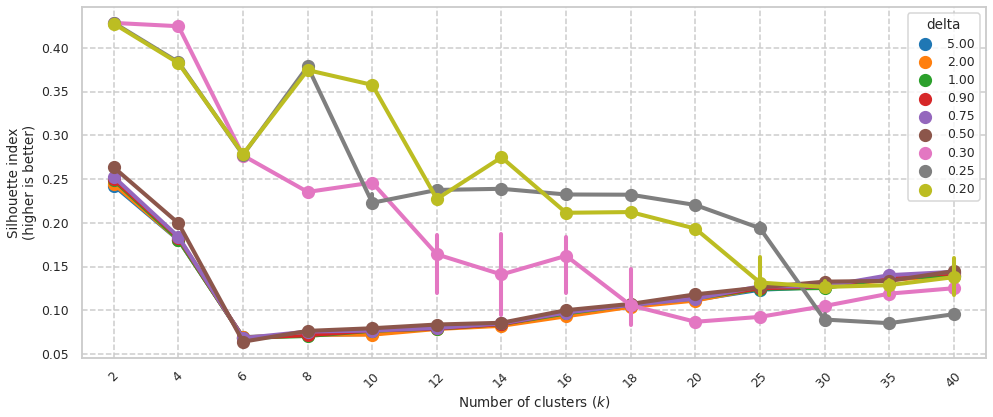

In [65]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score", hue="delta")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

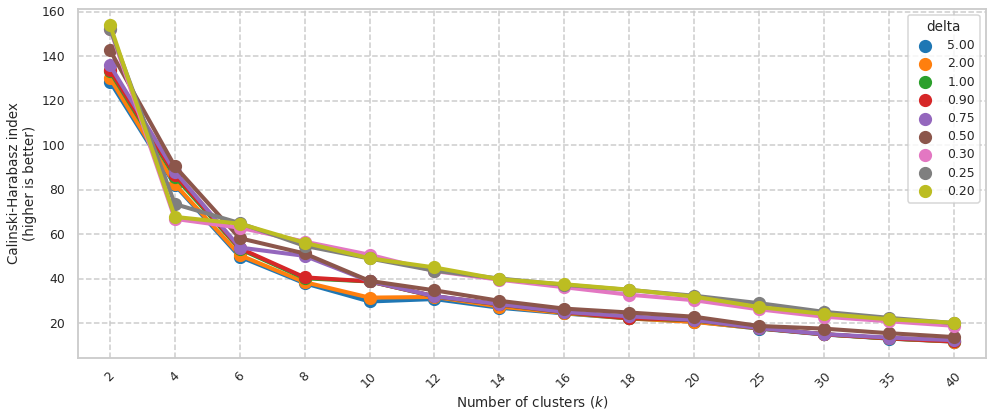

In [66]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="delta")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

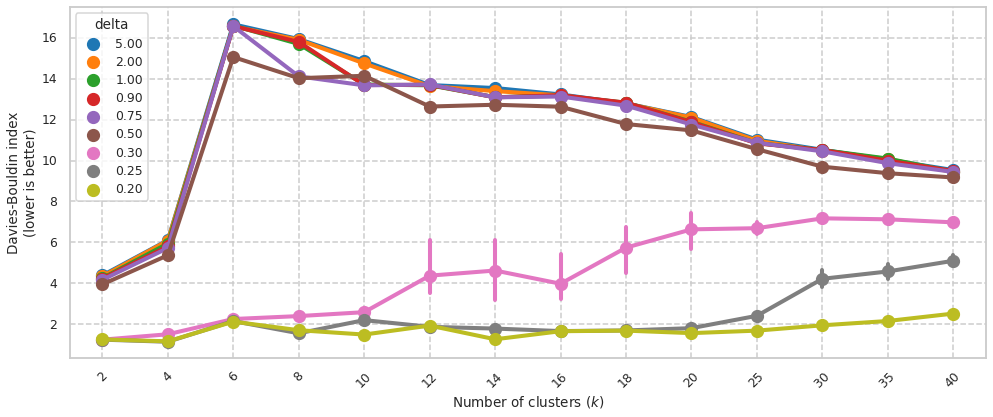

In [67]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score", hue="delta")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [68]:
parts = ensemble.groupby(["delta", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [69]:
parts.shape

(126,)

In [70]:
parts.head()

delta  n_clusters
0.20   2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       6             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       8             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       10            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [71]:
parts.iloc[0].shape

(5, 3749)

In [72]:
assert np.all(
    [
        parts.loc[k].shape == (int(CLUSTERING_OPTIONS["N_REPS_PER_K"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [73]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [74]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [75]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

0.20  2    1.0
0.30  2    1.0
1.00  2    1.0
      4    1.0
0.90  4    1.0
      2    1.0
0.75  6    1.0
      4    1.0
      2    1.0
0.50  4    1.0
2.00  2    1.0
0.50  2    1.0
0.30  8    1.0
      4    1.0
      6    1.0
Name: n_clusters, dtype: float64

In [76]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["gamma", "n_clusters"], inplace=True)

In [77]:
parts_ari_df.shape

(126, 10)

In [78]:
_n_total_parts = int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"]
)  # * len(CLUSTERING_OPTIONS["GAMMAS"]))

assert int(_n_total_parts * (_n_total_parts - 1) / 2) == parts_ari_df.shape[1]

In [79]:
parts_ari_df.head()

0    1    2    3    4    5    6    7    8    9
gamma n_clusters                                                  
0.20  2           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      4           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      6           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      8           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      10          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Stability plot

In [80]:
parts_ari_df_plot = (
    parts_ari_df.stack().reset_index().rename(columns={"level_2": "idx", 0: "ari"})
)

In [81]:
parts_ari_df_plot.dtypes

gamma          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [82]:
parts_ari_df_plot.head()

,gamma,n_clusters,idx,ari
0,0.20,2,0,1.0
1,0.20,2,1,1.0
2,0.20,2,2,1.0
3,0.20,2,3,1.0
4,0.20,2,4,1.0


In [83]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

idx       ari
n_clusters gamma               
2          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  1.000000
           0.75   4.5  1.000000
           0.90   4.5  1.000000
           1.00   4.5  1.000000
           2.00   4.5  1.000000
           5.00   4.5  1.000000
4          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  1.000000
           0.75   4.5  1.000000
           0.90   4.5  1.000000
           1.00   4.5  1.000000
           2.00   4.5  0.993919
           5.00   4.5  1.000000
6          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  0.996792
           0.75   4.5  1.000000
           0.90   4.5  0.999411
           1.00   4.5  0.995154
           2.00   4.5  0.984092
           5.00   4.5  0.991213
8          0.20   4.5  1.000000
           0.25   4.5  0.999976
           0.30   4.5  1.000000
           0.50   4.5  0.984497
           0.75   4.5  0.982437
           0.90   4.5  0.980833
           1.00   4.5  0.966565
           2.00   4.5  0.993389
           5.00   4.5  0.986965
10         0.20   4.5  1.000000
           0.25   4.5  0.899873
           0.30   4.5  0.998005
           0.50   4.5  0.986723
           0.75   4.5  0.976297
           0.90   4.5  0.979890
           1.00   4.5  0.987266
           2.00   4.5  0.976459
           5.00   4.5  0.977611
12         0.20   4.5  0.985296
           0.25   4.5  0.998916
           0.30   4.5  0.807272
           0.50   4.5  0.995121
           0.75   4.5  0.992760
           0.90   4.5  0.992068
           1.00   4.5  0.993909
           2.00   4.5  0.969995
           5.00   4.5  0.986701
14         0.20   4.5  0.996079
           0.25   4.5  0.998980
           0.30   4.5  0.675522
           0.50   4.5  0.870772
           0.75   4.5  0.988704
           0.90   4.5  0.989760
           1.00   4.5  0.972102
           2.00   4.5  0.884660
           5.00   4.5  0.820064
16         0.20   4.5  0.990620
           0.25   4.5  0.995089
           0.30   4.5  0.747181
           0.50   4.5  0.986218
           0.75   4.5  0.847363
           0.90   4.5  0.863503
           1.00   4.5  0.830640
           2.00   4.5  0.866661
           5.00   4.5  0.861173
18         0.20   4.5  0.967120
           0.25   4.5  0.996188
           0.30   4.5  0.502074
           0.50   4.5  0.847194
           0.75   4.5  0.797804
           0.90   4.5  0.861331
           1.00   4.5  0.861117
           2.00   4.5  0.955990
           5.00   4.5  0.922931
20         0.20   4.5  0.855124
           0.25   4.5  0.974847
           0.30   4.5  0.567486
           0.50   4.5  0.947888
           0.75   4.5  0.888675
           0.90   4.5  0.811565
           1.00   4.5  0.870871
           2.00   4.5  0.821736
           5.00   4.5  0.798859
25         0.20   4.5  0.980165
           0.25   4.5  0.924024
           0.30   4.5  0.499094
           0.50   4.5  0.815098
           0.75   4.5  0.834067
           0.90   4.5  0.775615
           1.00   4.5  0.783037
           2.00   4.5  0.787075
           5.00   4.5  0.794628
30         0.20   4.5  0.859143
           0.25   4.5  0.304671
           0.30   4.5  0.512587
           0.50   4.5  0.811116
           0.75   4.5  0.810547
           0.90   4.5  0.755169
           1.00   4.5  0.782872
           2.00   4.5  0.748817
           5.00   4.5  0.780548
35         0.20   4.5  0.927005
           0.25   4.5  0.360036
           0.30   4.5  0.594149
           0.50   4.5  0.823520
           0.75   4.5  0.820176
           0.90   4.5  0.829968
           1.00   4.5  0.767713
           2.00   4.5  0.799027
           5.00   4.5  0.819577
40         0.20   4.5  0.774045
           0.25   4.5  0.347876
           0.30   4.5  0.756114
           0.50   4.5  0.792539
           0.75   4.5  0.793490
           0.90   4.5  0.774088
           1.00   

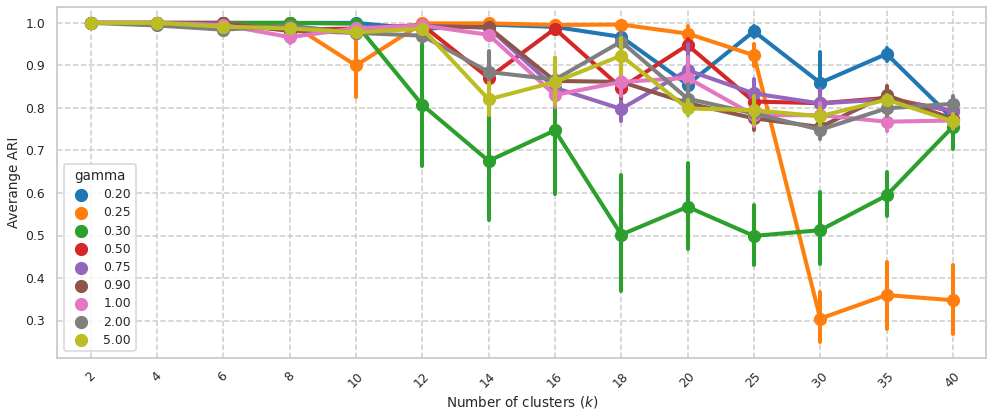

In [84]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="gamma")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

**CONCLUSION:** the best values for the `delta` parameter seem to be `0.20`, `0.25` and `0.30`. I will also consider `0.50`, since seem to yield potentially good results when `n_clusters` is high (see `umap` results).